In [1]:
!pip install plotly -q
!pip install s3fs -q

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve,r2_score
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings
from plotly.subplots import make_subplots
import seaborn as sns
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE

In [3]:
walmart = pd.read_csv("Walmart_Store_sales.csv")

walmart

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
...,...,...,...,...,...,...,...,...
145,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899
146,7.0,NaN,716388.81,NaN,20.74,2.778,NaN,NaN
147,17.0,11-06-2010,845252.21,0.0,57.14,2.841,126.111903,NaN
148,8.0,12-08-2011,856796.10,0.0,86.05,3.638,219.007525,NaN


In [4]:
walmart.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [5]:
walmart.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
mean,9.866667,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000


In [6]:
# Basic stats
print("Number of rows : {}".format(walmart.shape[0]))
print()

print("Display of dataset: ")
display(walmart.head())
print()

print("Basics statistics: ")
data_desc = walmart.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*walmart.isnull().sum()/walmart.shape[0])

Number of rows : 150

Display of dataset: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basics statistics: 


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values: 


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

In [7]:
print(walmart.iloc[:,2].isnull() )
index_avec_nan = walmart.index[walmart.iloc[:,2].isnull()]
walmart.drop(index_avec_nan,0, inplace=True)

0      False
1      False
2       True
3      False
4      False
       ...  
145    False
146    False
147    False
148    False
149    False
Name: Weekly_Sales, Length: 150, dtype: bool


In [8]:
walmart

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
5,4.0,28-05-2010,1857533.70,0.0,NaN,2.756,126.160226,7.896
...,...,...,...,...,...,...,...,...
145,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899
146,7.0,NaN,716388.81,NaN,20.74,2.778,NaN,NaN
147,17.0,11-06-2010,845252.21,0.0,57.14,2.841,126.111903,NaN
148,8.0,12-08-2011,856796.10,0.0,86.05,3.638,219.007525,NaN


In [9]:
# Conversion des valeurs de températures en °C => éviter des valeurs trop hautes
walmart['Temperature'] = ((walmart['Temperature'])-32)/1.8
walmart['Temperature']

0      15.338889
1       5.766667
3      29.205556
4      26.050000
5            NaN
         ...    
145    22.566667
146    -6.255556
147    13.966667
148    30.027778
149    12.888889
Name: Temperature, Length: 136, dtype: float64

In [10]:
# Create a second column conerning the date 

walmart['week'] =pd.to_datetime(walmart['Date']).dt.isocalendar().week
walmart['year'] = pd.to_datetime(walmart['Date']).dt.isocalendar().year
walmart['month'] = pd.to_datetime(walmart['Date']).dt.month
walmart['week_day'] = pd.to_datetime(walmart['Date']).dt.weekday
# The new Date column can be used thanks to the datetime format compare to 
# previous one
walmart['Date'] = pd.to_datetime(walmart['Date'])
walmart['Date'].sort_values()

14    2010-01-10
20    2010-02-04
47    2010-02-07
99    2010-02-07
112   2010-02-19
         ...    
92           NaT
102          NaT
129          NaT
137          NaT
146          NaT
Name: Date, Length: 136, dtype: datetime64[ns]

In [11]:
walmart.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment', 'week', 'year', 'month',
       'week_day'],
      dtype='object')

In [12]:
walmart.shape

(136, 12)

In [13]:
# On réorganise l'ordre des colonnes pour un df plus esthétique
walmart = walmart.iloc[:, [1,11,8,10,9,0,2,3,4,5,6,7]]
walmart

,Date,week_day,week,month,year,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,2011-02-18,4.0,7,2.0,2011,6.0,1572117.54,NaN,15.338889,3.045,214.777523,6.858
1,2011-03-25,4.0,12,3.0,2011,13.0,1807545.43,0.0,5.766667,3.435,128.616064,7.470
3,NaT,NaN,<NA>,NaN,<NA>,11.0,1244390.03,0.0,29.205556,NaN,214.556497,7.346
4,2010-05-28,4.0,21,5.0,2010,6.0,1644470.66,0.0,26.050000,2.759,212.412888,7.092
5,2010-05-28,4.0,21,5.0,2010,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896
...,...,...,...,...,...,...,...,...,...,...,...,...
145,2010-06-18,4.0,24,6.0,2010,14.0,2248645.59,0.0,22.566667,2.780,182.442420,8.899
146,NaT,NaN,<NA>,NaN,<NA>,7.0,716388.81,NaN,-6.255556,2.778,NaN,NaN
147,2010-11-06,5.0,44,11.0,2010,17.0,845252.21,0.0,13.966667,2.841,126.111903,NaN
148,2011-12-08,3.0,49,12.0,2011,8.0,856796.10,0.0,30.027778,3.638,219.007525,NaN


In [14]:
# Separate target variable Y from features X
target_variable = 'Weekly_Sales'


Y = walmart.loc[:,target_variable]
print(Y.head())
print()

0    1572117.54
1    1807545.43
3    1244390.03
4    1644470.66
5    1857533.70
Name: Weekly_Sales, dtype: float64



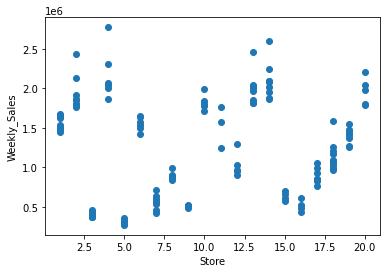

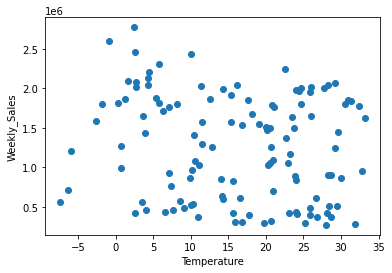

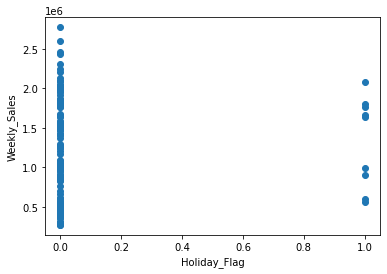

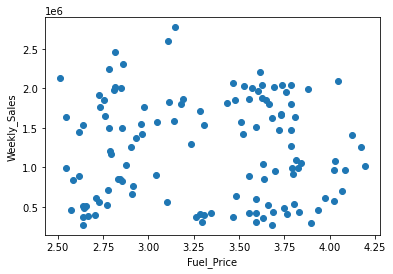

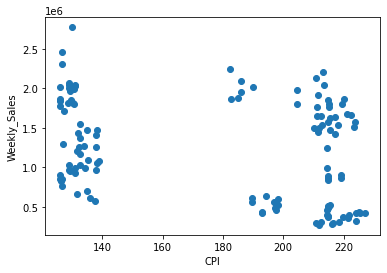

In [15]:
def scatter_visu(column):
    plt.scatter(x = walmart[column],y = walmart['Weekly_Sales'])
    plt.ylabel('Weekly_Sales')
    plt.xlabel(column)
    plt.show()
scatter_visu('Store')
scatter_visu('Temperature')
scatter_visu('Holiday_Flag')
scatter_visu('Fuel_Price')
scatter_visu('CPI')

In [16]:
px.histogram(walmart, x = walmart['Temperature'],y = walmart['Weekly_Sales'])    

In [17]:
walmart

,Date,week_day,week,month,year,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,2011-02-18,4.0,7,2.0,2011,6.0,1572117.54,NaN,15.338889,3.045,214.777523,6.858
1,2011-03-25,4.0,12,3.0,2011,13.0,1807545.43,0.0,5.766667,3.435,128.616064,7.470
3,NaT,NaN,<NA>,NaN,<NA>,11.0,1244390.03,0.0,29.205556,NaN,214.556497,7.346
4,2010-05-28,4.0,21,5.0,2010,6.0,1644470.66,0.0,26.050000,2.759,212.412888,7.092
5,2010-05-28,4.0,21,5.0,2010,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896
...,...,...,...,...,...,...,...,...,...,...,...,...
145,2010-06-18,4.0,24,6.0,2010,14.0,2248645.59,0.0,22.566667,2.780,182.442420,8.899
146,NaT,NaN,<NA>,NaN,<NA>,7.0,716388.81,NaN,-6.255556,2.778,NaN,NaN
147,2010-11-06,5.0,44,11.0,2010,17.0,845252.21,0.0,13.966667,2.841,126.111903,NaN
148,2011-12-08,3.0,49,12.0,2011,8.0,856796.10,0.0,30.027778,3.638,219.007525,NaN


In [18]:
# Now we will remove all the outliers in our dataframe
print('Nombre de ligne',walmart[:].shape [0])
mask = True
liste_col = ('Temperature','Fuel_Price','CPI')
for element in liste_col:
    borne_inf = walmart[element].mean() - 3*walmart[element].std()
    borne_sup = walmart[element].mean() + 3*walmart[element].std()
    mask = ((walmart[element] > borne_inf) | (walmart[element]) < borne_sup)
    walmart = walmart.loc[mask,:]
walmart.value_counts()

Nombre de ligne 136


Date        week_day  week  month  year  Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  CPI         Unemployment
2012-12-10  0.0       50    12.0   2012  18.0   1074079.00    0.0           10.538889    4.029       138.911700  8.243           1
2010-09-17  4.0       37    9.0    2010  8.0    836707.85     0.0           24.066667    2.582       214.878556  6.315           1
2010-10-12  1.0       41    10.0   2010  4.0    2302504.86    0.0           5.777778     2.860       126.793400  7.127           1
                                         13.0   2461468.35    0.0           2.655556     2.817       126.793400  7.795           1
2010-10-15  4.0       41    10.0   2010  18.0   1029618.10    0.0           11.122222    2.878       132.763355  9.331           1
                                                                                                                                ..
2011-12-08  3.0       49    12.0   2011  13.0   1970341.38    0.0           24.416667   

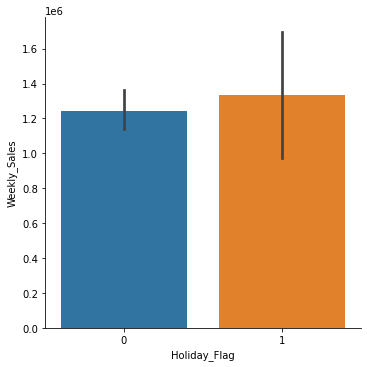

In [19]:
# On vérifie si en jour spécial, cela influe sur les ventes.

walmart['Holiday_Flag'] = walmart['Holiday_Flag'].apply(lambda x : 1 if x == 1 else 0)

sns.catplot(x= walmart['Holiday_Flag'], y = "Weekly_Sales", data = walmart, kind="bar")

# On voit que cela ne change rien au C.A. de Walmart que ce soit un jour spécial 
#ou non.
# Nous allons donc supprimer cette colonne, puisque pour moi elle est inutile et
# rendrait la pred plus imprécise.

In [20]:
walmart['Store'] = walmart['Store'].astype(int)
walmart['Store']

0       6
1      13
3      11
4       6
5       4
       ..
145    14
146     7
147    17
148     8
149    19
Name: Store, Length: 136, dtype: int64

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

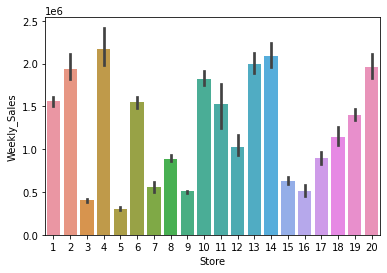

In [21]:
sns.barplot(data=walmart, x='Store', y='Weekly_Sales')

In [22]:
walmart['Store']

0       6
1      13
3      11
4       6
5       4
       ..
145    14
146     7
147    17
148     8
149    19
Name: Store, Length: 136, dtype: int64

In [23]:
# Drop the Holiday_Flag column 
#holiday = ['Holiday_Flag']

#print("Dropping the useless column...")
#walmart = walmart.drop(holiday, axis=1)
#print(walmart.head())
#print("...Done. Date column is dropped")

In [24]:
walmart

,Date,week_day,week,month,year,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,2011-02-18,4.0,7,2.0,2011,6,1572117.54,0,15.338889,3.045,214.777523,6.858
1,2011-03-25,4.0,12,3.0,2011,13,1807545.43,0,5.766667,3.435,128.616064,7.470
3,NaT,NaN,<NA>,NaN,<NA>,11,1244390.03,0,29.205556,NaN,214.556497,7.346
4,2010-05-28,4.0,21,5.0,2010,6,1644470.66,0,26.050000,2.759,212.412888,7.092
5,2010-05-28,4.0,21,5.0,2010,4,1857533.70,0,NaN,2.756,126.160226,7.896
...,...,...,...,...,...,...,...,...,...,...,...,...
145,2010-06-18,4.0,24,6.0,2010,14,2248645.59,0,22.566667,2.780,182.442420,8.899
146,NaT,NaN,<NA>,NaN,<NA>,7,716388.81,0,-6.255556,2.778,NaN,NaN
147,2010-11-06,5.0,44,11.0,2010,17,845252.21,0,13.966667,2.841,126.111903,NaN
148,2011-12-08,3.0,49,12.0,2011,8,856796.10,0,30.027778,3.638,219.007525,NaN


In [25]:
walmart.columns

Index(['Date', 'week_day', 'week', 'month', 'year', 'Store', 'Weekly_Sales',
       'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [26]:
del_columns = ['Date', 'week', 'year']
walmart = walmart.drop(del_columns, axis = 1)
walmart

,week_day,month,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,4.0,2.0,6,1572117.54,0,15.338889,3.045,214.777523,6.858
1,4.0,3.0,13,1807545.43,0,5.766667,3.435,128.616064,7.470
3,NaN,NaN,11,1244390.03,0,29.205556,NaN,214.556497,7.346
4,4.0,5.0,6,1644470.66,0,26.050000,2.759,212.412888,7.092
5,4.0,5.0,4,1857533.70,0,NaN,2.756,126.160226,7.896
...,...,...,...,...,...,...,...,...,...
145,4.0,6.0,14,2248645.59,0,22.566667,2.780,182.442420,8.899
146,NaN,NaN,7,716388.81,0,-6.255556,2.778,NaN,NaN
147,5.0,11.0,17,845252.21,0,13.966667,2.841,126.111903,NaN
148,3.0,12.0,8,856796.10,0,30.027778,3.638,219.007525,NaN


In [27]:
#miss_values = walmart.dropna(subset = ['Date'])
#date = ['Date']
#week = ['week']
#year = ['year']
#walmart = walmart.drop(['Date'], ['week'], axis=1)
#miss_values

In [28]:
#Now we'll going to preprocess our machine learning

# Separate target variable Y from features X
target_name = 'Weekly_Sales'

print("Separating labels from features...")
Y = walmart.loc[:,target_name]
X = walmart.loc[:,[c for c in walmart.columns if c!=target_name]] # All columns are kept, except the target
print("...Done.")
print(Y.head())
print()
print(X.head())
print()

Separating labels from features...
...Done.
0    1572117.54
1    1807545.43
3    1244390.03
4    1644470.66
5    1857533.70
Name: Weekly_Sales, dtype: float64

   week_day  month  Store  Holiday_Flag  Temperature  Fuel_Price         CPI  \
0       4.0    2.0      6             0    15.338889       3.045  214.777523   
1       4.0    3.0     13             0     5.766667       3.435  128.616064   
3       NaN    NaN     11             0    29.205556         NaN  214.556497   
4       4.0    5.0      6             0    26.050000       2.759  212.412888   
5       4.0    5.0      4             0          NaN       2.756  126.160226   

   Unemployment  
0         6.858  
1         7.470  
3         7.346  
4         7.092  
5         7.896  



In [29]:
# Divide dataset Train set & Test set 
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [30]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()
print("...Done")

print(X_train[0:5,:])
print(X_test[0:2,:])
print()
print(Y_train[0:5])
print(Y_test[0:2])

Convert pandas DataFrames to numpy arrays...
...Done
[[  4.           6.           9.           0.          28.32777778
    2.637      215.0166484    6.384     ]
 [  4.          10.          18.           0.          11.12222222
    2.878      132.7633548    9.331     ]
 [         nan          nan  11.           0.          29.20555556
           nan 214.5564968    7.346     ]
 [  3.           6.          10.           0.          30.48333333
    3.666      130.7196333    7.17      ]
 [  4.           5.          18.           0.          20.62222222
    2.906      132.2939355           nan]]
[[  4.           4.          17.           0.           7.34444444
    2.915      126.5621       6.635     ]
 [         nan          nan   3.           0.          15.62222222
    3.555      224.1320199    6.833     ]]

[513073.87, 1029618.1, 1244390.03, 1805999.79, 1256282.79]
[757738.76, 418925.47]


In [31]:
# Automatically detect positions of numeric/categorical features

# Create pipeline for numeric features
numeric_features = [4,5,6,7]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])


# Create pipeline for categorical features
categorical_features = [0,1,2,3]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by the mean value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [32]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [33]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train[0:5,:])
X_train = preprocessor.fit_transform(X_train)
X_train = X_train.todense()
print('...Done.')
print(X_train[0:5,:])
print()

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test[0:5,:])
X_test = preprocessor.transform(X_test)
X_test = X_test.todense()
# Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:])
print()

Performing preprocessings on train set...
[[  4.           6.           9.           0.          28.32777778
    2.637      215.0166484    6.384     ]
 [  4.          10.          18.           0.          11.12222222
    2.878      132.7633548    9.331     ]
 [         nan          nan  11.           0.          29.20555556
           nan 214.5564968    7.346     ]
 [  3.           6.          10.           0.          30.48333333
    3.666      130.7196333    7.17      ]
 [  4.           5.          18.           0.          20.62222222
    2.906      132.2939355           nan]]
...Done.
[[ 1.18934649 -1.52431461  0.94655621 -0.75467675  0.          0.
   1.          0.          0.          0.          0.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.  

In [34]:
# Train model
print("Train model...")
linear = LinearRegression()
linear.fit(X_train, Y_train)
print("...Done.")

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = linear.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = linear.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Train model...
...Done.
Predictions on training set...
...Done.
[ 526235.17883175 1093136.66201378 1455558.95318866 1809303.8678312
 1139232.67339425  465248.09490655 2153588.98962556  395372.62948081
  470299.36352866 1551757.92973277 1495212.0801617   931899.26783321
  376547.19160541  819479.84390279  292203.08322364 2056130.26886698
 1214800.36986373  354332.12856959 2076647.1882153   487663.60887835
  464318.92092958 2078804.41201951 2381439.48897906 1584484.40407148
  704960.13707224  951443.64581188 2017969.1088737  1868688.24979059
 2158145.31998048  850691.50151665  203465.79352915 1533843.54714654
 1911749.22687558  481467.39814503  854496.86549969 1353560.85620345
  593575.46434361 1133931.35865052  465550.49759518 2049823.38806348
  404662.48683503 1656585.01587897 1117751.21073897 1997000.50033097
 1782213.62683513 2166750.83533635 1953485.35010131 2046229.23695121
 2004568.90242366  449677.15853505  633507.76160493  897703.03321018
  431559.89030173 1967453.0411833  16566

In [35]:
# Print R^2 scores
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

R2 score on training set :  0.9697576920546288
R2 score on test set :  0.9422803340505674


#  
#### The model is rather good : no overfitting, and the R2 score is significantly > 0 so we are performing way better than a "dummy" model. 
#### Now let's have a look at the coefficients now

In [46]:
from sklearn.metrics import mean_squared_error

#The different coefficients
print ("\nThe coefficients:\n", linear.coef_,linear)
print('---')
# The mean squarred error
print ("\nThe Mean Squarred Error on test set:\n", mean_squared_error(Y_test, Y_test_pred))
print('It means that we predict the test Weekly_sales with a mean error of {} dollars '.format(int(mean_squared_error(Y_test, Y_test_pred)**0.5)))


The coefficients:
 [  -34654.97441301   -45800.62365557    77046.86065081   -95112.66937878
   132136.29662012   -78138.51835319    26763.92009084   -83525.97919204
   110520.83408075   146359.35555835   125768.85990057   101989.09548336
   102385.54673943   183129.83313267    98902.34135228   113655.76776423
    63884.40803832   131125.96379164   249282.37383558   253786.15802742
   362819.64382509 -1228975.9506317    674705.06288382 -1288922.53648827
    24751.41063366  -954356.06748597  -744508.64152483 -1163726.48824928
   544625.61875127  -162311.24478897    40146.35228991   594079.68448606
   550190.95472476  -736848.66865381 -1039874.43046644  -592569.3013062
  -252935.13695469    16635.10410821   433383.48978042     8839.38052204] LinearRegression()
---

The Mean Squarred Error on test set:
 24483062764.18143
It means that we predict the test Weekly_sales with a mean error of 156470 dollars 


In [76]:
features = list(preprocessor.transformers_[1][1]['encoder'].get_feature_names())
features
numeric = ['Temperature','Fuel_Price','CPI','Unemployment']
Z = features + numeric
Z = pd.DataFrame(Z, columns=['features'])
coef = pd.DataFrame(linear.coef_,columns=['coefficient'])
coeff = pd.concat([Z,coef],axis=1)
coeff.groupby(['coefficient']).sort
coeff

,features,coefficient
0,x0_1.0,-3.465497e+04
1,x0_3.0,-4.580062e+04
2,x0_4.0,7.704686e+04
3,x0_5.0,-9.511267e+04
4,x0_6.0,1.321363e+05
5,x1_2.0,-7.813852e+04
6,x1_3.0,2.676392e+04
7,x1_4.0,-8.352598e+04
8,x1_5.0,1.105208e+05
9,x1_6.0,1.463594e+05


In [93]:
coef_num = pd.DataFrame(index = Z, data = { 'coefficients' : linear.coef_[:],
                                                  #‘pvalues’ : ols_fit.pvalues[1:5] }
                                                }).sort_values('coefficients')

coef_num.apply(lambda x : abs(x)).sort_values(by="coefficients", ascending=False)

,coefficients
"(x2_9.0,)",1.288923e+06
"(x2_7.0,)",1.228976e+06
"(x2_13.0,)",1.163726e+06
"(x2_20.0,)",1.039874e+06
"(x2_11.0,)",9.543561e+05
"(x2_12.0,)",7.445086e+05
"(x2_19.0,)",7.368487e+05
"(x2_8.0,)",6.747051e+05
"(x2_17.0,)",5.940797e+05
"(x3_1.0,)",5.925693e+05


### Ridge

In [42]:
# Perform 3-fold cross-validation to evaluate the generalized R2 score obtained with a Ridge model
print("3-fold cross-validation...")
regressor = Ridge()
scores = cross_val_score(regressor, X_train, Y_train, cv=4)
#scores = cross_val_score(regressor, X_train, Y_train, cv=5)
print('The cross-validated R2-score is : ', scores.mean())
print('The standard deviation is : ', scores.std())

3-fold cross-validation...
The cross-validated R2-score is :  0.8288684457279762
The standard deviation is :  0.04421677870511798


In [43]:
# Perform grid search
print("Grid search...")
# Grid of values to be tested
params = {
    'alpha': [0.0, 0.00001, 0.001, 0.1, 0.2, 0.5, 1.0, 10, 100] # 0 corresponds to no regularization
}
gridsearch = GridSearchCV(regressor, param_grid = params, cv = 6) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best R2 score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'alpha': 0.1}
Best R2 score :  0.9127894618852546


In [44]:
# Predictions on training set
# The model has already be re-trained on all the training set at the end of the grid search, so we can directly use it !
print("Predictions on training set...")
Y_train_ridge_pred = gridsearch.predict(X_train)
print("...Done.")
#print(Y_train_pred)
#print()

# Predictions on test set
print("Predictions on test set...")
Y_test_ridge_pred = gridsearch.predict(X_test)
print("...Done.")
#print(Y_test_pred)
#print()

# Print R^2 scores on train/test sets for the Ridge model with optimal value of the regularization strength
print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))
print ("\nThe Mean Squarred Error on test set:\n", mean_squared_error(Y_test, Y_test_ridge_pred))
print('It means that we predict the test Weekly_sales with a mean error of {} dollars '.format(int(mean_squared_error(Y_test, Y_test_ridge_pred)**0.5)))

Predictions on training set...
...Done.
Predictions on test set...
...Done.
R2 score on training set :  0.9697576920546288
R2 score on test set :  0.9422803340505674

The Mean Squarred Error on test set:
 27292365655.379612
It means that we predict the test Weekly_sales with a mean error of 165204 dollars 


## 

## We can see that Ridge model isn't higher than our first model. If we look at our R2 and MSE, they were better than the Ridge, so we can keep the first model.